In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal

from utils import *

In [2]:
class RaceNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=28, output_dim=2):
        super(RaceNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, races1, races2):

        x = torch.cat((races1, races2), dim=1)

        return self.net(x)

In [3]:
def model(game_info, obs):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    # Extract the game information
    ids1 = game_info['coach1_ids']
    ids2 = game_info['coach2_ids']
    races1 = game_info['races1']
    races2 = game_info['races2']
    num_coaches = game_info['num_coaches']    

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    num_games = obs.shape[0]
    num_races = len(races1[0])

    NN = RaceNet(2*num_races)

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', num_games):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Get racial bias
        biases = NN(races1, races2)
        coach1_biases = biases[:, 0]
        coach2_biases = biases[:, 1]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills - coach1_biases , hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills - coach2_biases, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [4]:
# load and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))

sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)
num_games = len(obs)

race1 = df['team1_race_name'].values
race2 = df['team2_race_name'].values

unique_categories1, indices1 = np.unique(race1 , return_inverse=True)
unique_categories2, indices2 = np.unique(race2 , return_inverse=True)

indices_tensor1 = torch.tensor(indices1)
num_categories = len(unique_categories1)
race1_one_hot = torch.nn.functional.one_hot(indices_tensor1, num_classes=num_categories).float()

indices_tensor2 = torch.tensor(indices2)
race2_one_hot = torch.nn.functional.one_hot(indices_tensor2, num_classes=num_categories).float()

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches, 'races1': race1_one_hot, 'races2': race2_one_hot}


In [5]:
guide = AutoNormal(model)
losses = run_inference(model, guide, game_info, obs, num_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss = 560648.867920: 100%|██████████| 1000/1000 [01:04<00:00, 15.41it/s]


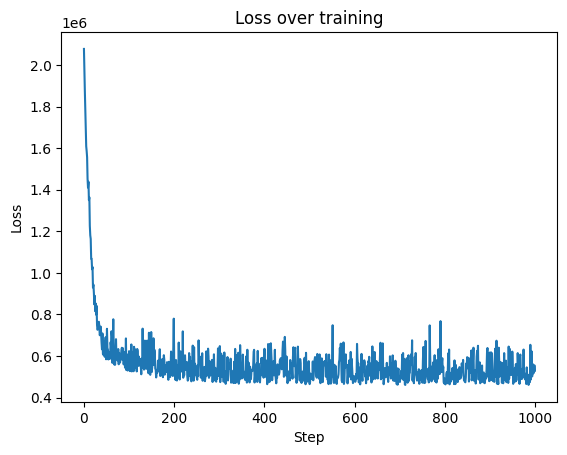

In [6]:
# plot the loss
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over training")
plt.show()


In [8]:
predictive = Predictive(model, guide=guide, num_samples=2000)

samples = predictive(game_info, obs)

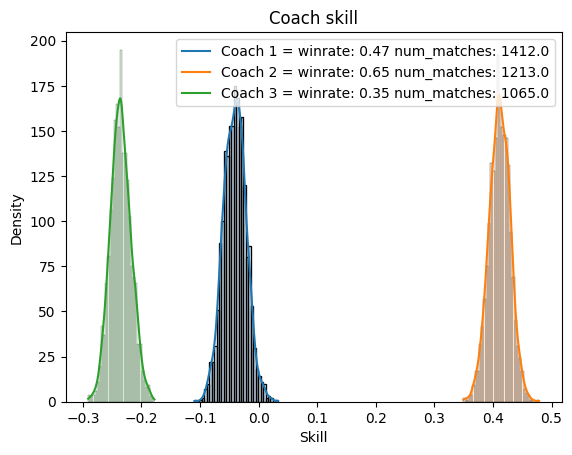

In [9]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


In [28]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

fig = go.Figure()

for i in range(3):
    fig.add_trace(go.Histogram(x=samples["coach_skills"].detach().squeeze()[:,i], 
                               name=f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}",
                               histnorm='probability density'))

fig.update_layout(barmode='overlay', 
                  xaxis_title="Skill", 
                  yaxis_title="Density", 
                  title="Coach skill",
                  legend=dict(
        x=0.4,  # x position
        y=1,  # y position
        bgcolor='rgba(0, 0, 0, .8)',  # transparent background
        bordercolor='rgba(255, 255, 255, 0)'  # transparent border
    ))

fig.show()